### Problème :
#### Utilisations du modèle SVM pour l’analyse des sentiments des phrases issues d’une base d’exemples qui contient des tweets étiquetés avec un sentiment positif ou négatif, voir la base d’exemples :
 

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import os
import io
import cvxopt

In [4]:
positive_folder = "C:\\Users\\dell i7 8 5500\\Downloads\\Twitter\\Positive"
negative_folder = "C:\\Users\\dell i7 8 5500\\Downloads\\Twitter\\Negative"

In [5]:
tweets = []  # List to store the tweets
sentiments = [] # List to store the sentiments (positive/negative)


In [6]:
#Loop through the positive folder and read the contents of each file
for filename in os.listdir(positive_folder):
    with io.open(os.path.join(positive_folder, filename), 'r', encoding='utf-8') as file:
        tweets.append(file.read())
        sentiments.append(1)  # 1 indicates positive


In [7]:
#Repeat the same thing for the negative folder, changing the label to 0
for filename in os.listdir(negative_folder):
    try:
        with io.open(os.path.join(negative_folder, filename), 'r', encoding='utf-8') as file:
            tweets.append(file.read())
            sentiments.append(-1)  # -1 indicates negative
    except UnicodeDecodeError:
        #print("Error: Failed to decode file -", filename)
        continue


In [8]:
#Combine the emails and labels into a Pandas dataframe:
df = pd.DataFrame({'tweets': tweets, 'sentiments': sentiments})


In [9]:
#Ce code effectue le mélange (shuffle) aléatoire des lignes du dataframe df. Cela garantit que les tweets négatifs et positifs sont mélangés de manière aléatoire afin d'éviter un éventuel biais dans les données. L'argument frac=1 indique de prendre une fraction de 1, c'est-à-dire de sélectionner toutes les lignes du dataframe. La méthode reset_index(drop=True) réinitialise l'index du dataframe après le mélange pour éviter d'avoir un index désordonné.
df = df.sample(frac=1).reset_index(drop=True)


In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\dell i7 8
[nltk_data]     5500\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopwords_arabic = stopwords.words('arabic')


In [12]:
#Removing common words that do not carry much meaning or contribute significantly to the overall understanding of the text.
def remove_arabic_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word not in stopwords_arabic]
    clean_text = ' '.join(clean_words)
    return clean_text

# Applying the 'remove_arabic_stopwords' function to our 'tweet' column
df['tweets'] = df['tweets'].apply(remove_arabic_stopwords)


In [13]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        """
        Initialisation de la classe SVM.

        Args:
            learning_rate (float): Taux d'apprentissage.
            lambda_param (float): Paramètre de régularisation.
            n_iters (int): Nombre d'itérations.
        """
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        """
        Entraîne le modèle SVM sur les données d'entraînement.

        Args:
            X (array-like): Matrice des échantillons d'entraînement.
            y (array-like): Vecteur des étiquettes d'entraînement.
        """
        n_samples, n_features = X.shape

        # Convertit les étiquettes en -1 et 1
        y_ = np.where(y <= 0, -1, 1)

        # Initialise les poids
        self.w = np.zeros(n_features)
        self.b = 0

        # Entraînement du modèle
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        """
        Prédit les étiquettes pour de nouveaux échantillons.

        Args:
            X (array-like): Matrice des échantillons à prédire.

        Returns:
            array: Vecteur d'étiquettes prédites.
        """
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def get_params(self, deep):
        """
        Renvoie les paramètres du modèle.

        Args:
            deep (bool): Ignoré dans cette implémentation.

        Returns:
            Tuple: Paramètres du modèle.
        """
        return self.lr, self.lambda_param, self.n_iters


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
# Séparation des caractéristiques (tweets) et des étiquettes (sentiments)
X = df['tweets']
y = df['sentiments']

# Création d'un objet TfidfVectorizer pour convertir les tweets en vecteurs de caractéristiques pondérées
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
X = X.toarray()

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:
# Liste des différentes valeurs de taux d'apprentissage à tester
learning_rate_params = [0.001, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030]

# Liste des différentes valeurs de paramètres lambda à tester
lambda_params = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.025]

# Liste des différents nombres d'itérations à tester
n_iters = [100, 250, 500, 750, 1000, 1250, 1500, 2000]

# Initialisation des meilleures mesures et des meilleures combinaisons d'hyperparamètres
best_recall = 0
best_recall_params = []
best_precision = 0
best_precision_params = []
best_accuracy = 0
best_accuracy_params = []

# Boucles pour itérer à travers toutes les combinaisons d'hyperparamètres
for item in learning_rate_params:
    for lb in lambda_params:
        for it in n_iters:
            # Création d'une instance de la classe SVM avec les hyperparamètres actuels
            svm = SVM(learning_rate=item, lambda_param=lb, n_iters=it)

            # Entraînement du modèle SVM sur les données d'entraînement
            svm.fit(X_train, y_train)

            # Prédictions du modèle SVM sur les données de test
            y_pred = svm.predict(X_test)

            # Affichage des performances pour les hyperparamètres actuels
            print(f"For params: learning_rate={item}, lambda={lb}, n of iterations={it}:")
            accuracy = accuracy_score(y_test, y_pred)
            print("Accuracy:", accuracy)
            precision = metrics.precision_score(y_test, y_pred)
            print("Precision:", precision)
            recall = metrics.recall_score(y_test, y_pred)
            print("Recall:", recall)

            # Mise à jour des meilleures mesures et des meilleures combinaisons d'hyperparamètres si nécessaire
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_accuracy_params = [item, lb, it]
            if recall > best_recall:
                best_recall = recall
                best_recall_params = [item, lb, it]
            if precision > best_precision:
                best_precision = precision
                best_precision_params = [item, lb, it]


for params : learning_rate=0.001 , lambda=0.0001, n of iteration = 100  :
Accuracy: 0.8320802005012531
Precision: 0.8473684210526315
Recall: 0.8090452261306532
for params : learning_rate=0.001 , lambda=0.0001, n of iteration = 250  :
Accuracy: 0.7944862155388471
Precision: 0.8823529411764706
Recall: 0.678391959798995
for params : learning_rate=0.001 , lambda=0.0001, n of iteration = 500  :
Accuracy: 0.8170426065162907
Precision: 0.8795180722891566
Recall: 0.7336683417085427
for params : learning_rate=0.001 , lambda=0.0001, n of iteration = 750  :
Accuracy: 0.849624060150376
Precision: 0.8971428571428571
Recall: 0.7889447236180904
for params : learning_rate=0.001 , lambda=0.0001, n of iteration = 1000  :
Accuracy: 0.8471177944862155
Precision: 0.875
Recall: 0.8090452261306532
for params : learning_rate=0.001 , lambda=0.0001, n of iteration = 1250  :
Accuracy: 0.8521303258145363
Precision: 0.8723404255319149
Recall: 0.8241206030150754
for params : learning_rate=0.001 , lambda=0.0001, n o

KeyboardInterrupt: 

In [19]:
print(best_accuracy_params)
print(best_precision_params)
print(best_recall_params)

[0.001, 0.0001, 1500]
[0.001, 0.0001, 750]
[0.001, 0.0005, 100]


In [21]:
# Création d'une instance de la classe SVM avec des hyperparamètres spécifiques
svm = SVM(learning_rate=0.001, lambda_param=0.0001, n_iters=1500)

# Entraînement du modèle SVM sur les données d'entraînement
svm.fit(X_train, y_train)

# Prédictions du modèle SVM sur les données de test
y_pred = svm.predict(X_test)


In [22]:
print(y_pred)

[ 1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.
 -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1.
 -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1.
  1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.
 -1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.
  1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1.
  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.
  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1

In [23]:
# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8546365914786967


The accuracy value of 0.8546365914786967 represents the overall correctness of the model’s predictions. It indicates that approximately 85.46% of the predictions made by the model are correct.

In [24]:
from sklearn import metrics

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))


Precision: 0.873015873015873
Recall: 0.8291457286432161


#### Precision: 0.873015873015873
This means that out of all the positive predictions made by the model, approximately 87.30% were correct.
#### Recall: 0.8291457286432161
This means that the model correctly identified approximately 82.91% of the positive samples.

#### Visualize the model's predictions compared to the actual sentiments using a confusion matrix. This matrix shows the true positive, true negative, false positive, and false negative values.

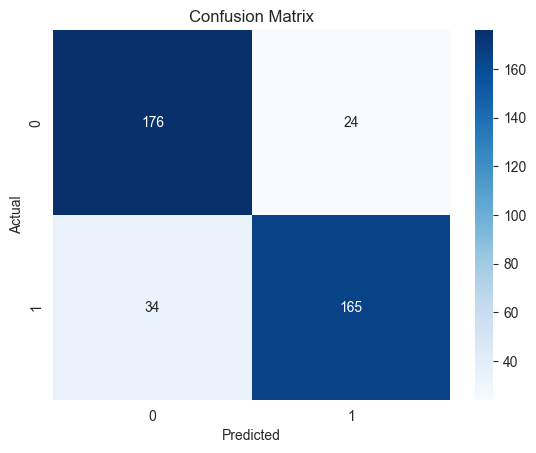

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


True Positives (TP): 176
These are the cases where the model correctly predicted the positive class.

True Negatives (TN): 165
These are the cases where the model correctly predicted the negative class.

False Negatives (FN): 24
These are the cases where the actual class was positive, but the model incorrectly predicted them as negative.

False Positives (FP): 34
These are the cases where the actual class was negative, but the model incorrectly predicted them as positive.